In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

# Sage and Lorenzo, edit the path to sasview for sas below
import sas


In [2]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Liquid_Samples/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
cp_conc = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer Concentration']))
matrix_conc = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer Concentration']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

In [22]:
sans_data.keys()

dict_keys(['TU11', 'TU19', 'TU20', 'TU24', 'TU25'])

In [63]:
names = {'TU11': 'RRe-P3HT at 5 mg/mL',
 'TU19': 'RRe-P3HT at 5 mg/mL + PS-H8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU20': 'PS-H8 at 45 mg/mL',
 'TU24': 'RRe-P3HT at 5 mg/mL + PS-D8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU25': 'PS-D8 at 45 mg/mL'}

In [48]:
slds = {'RRe-P3HT':0.676,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426,
       'Toluene-D8':5.664}


In [49]:
file_info = pd.read_csv('../../data/sans/Liquid_Samples/File_Info.csv')
file_assign = dict(zip(file_info['Filename'], file_info['Sample']))

data_dir = '../../data/sans/Liquid_Samples/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = str(file.split('_')[0][:4])
        usans_data[key] = np.loadtxt(data_dir + file,skiprows=4)
    elif 'sans' in file:
        key = file_assign[file]
        if key in sans_data.keys():
            sans_data[key].append(np.loadtxt((data_dir + file),skiprows=12))
        else:
            sans_data[key] = [np.loadtxt((data_dir + file),skiprows=12)]
            
for key, (data1, data2) in sans_data.items():
    x = np.concatenate((data1[:,0], data2[:,0]))
    y = np.concatenate((data1[:,1], data2[:,1]))
    dx = np.concatenate((data1[:,3], data2[:,3]))
    dy = np.concatenate((data1[:,2], data2[:,2]))
    sans_data[key] = sasmodels.data.Data1D(x, y, dx=dx, dy=dy)
    
for key, data in usans_data.items():
    usans_data[key] = sasmodels.data.Data1D(data[:,0],data[:,1],dy=data[:,2])

In [50]:
for key, data in sans_data.items():
    filename = 'Merged_' + key + '.ABS'
    x = data.x
    y = data.y
    dy = data.dy
    
    comb = np.vstack((x,y,dy)).T
    np.savetxt('../../data/sans/Liquid_Samples/' + filename, comb, header='<X> <Y> <dY>')

In [51]:
usans_data

{'TU11': <sasmodels.data.Data1D at 0x127c891f0>,
 'TU19': <sasmodels.data.Data1D at 0x12447dd90>,
 'TU20': <sasmodels.data.Data1D at 0x124a922b0>}

In [55]:
colors = {
    'TU11':'firebrick',
    'TU19':'mediumblue',
    'TU20':'darkorchid',
    'TU24':'darkcyan',
    'TU25':'black',
}

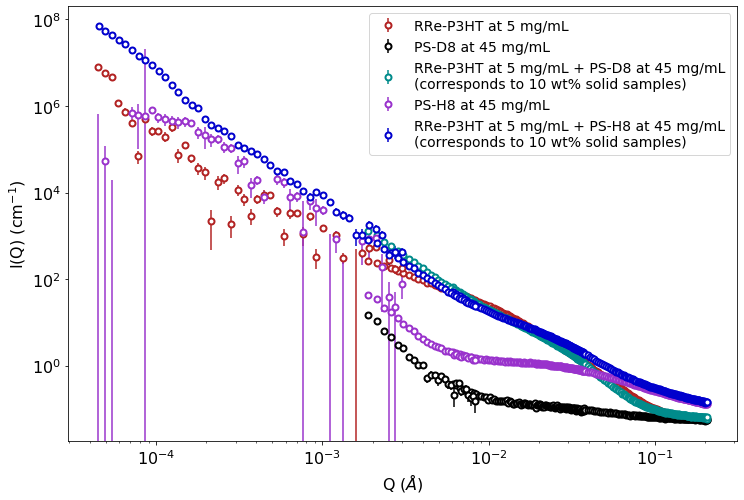

In [64]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU25','TU24','TU20','TU19']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

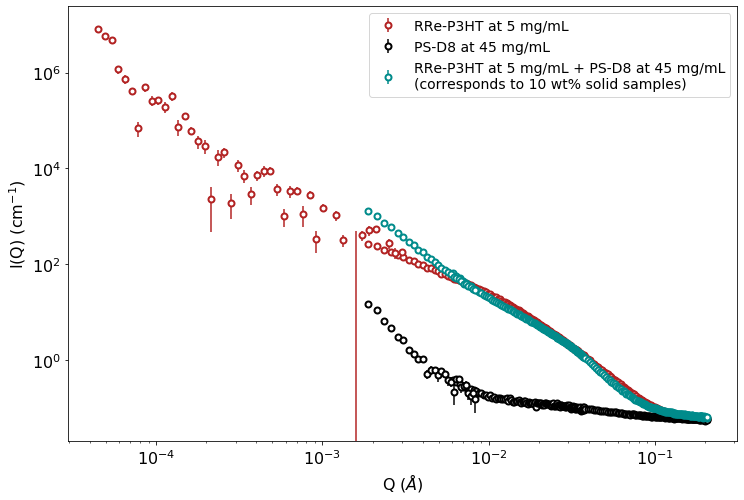

In [65]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU25','TU24']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

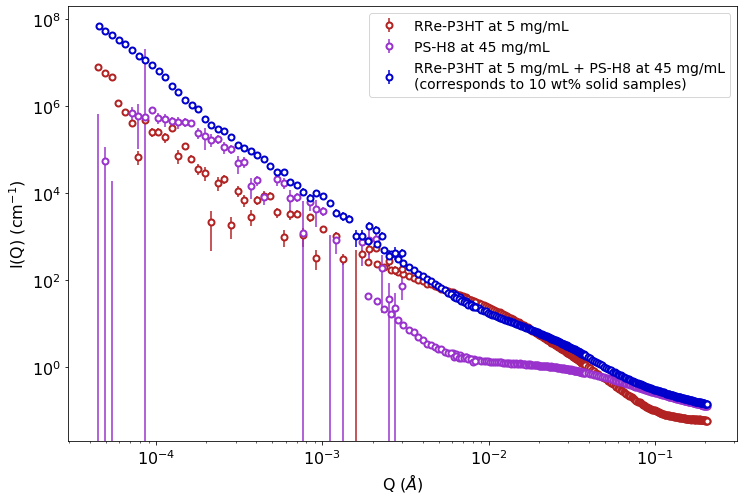

In [66]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU20','TU19']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## RRe-P3HT at 5 mg/mL Sample (TU11)

final chisq 87.442(26)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              background 0.06719(10)     0.067190(11)   
                             kuhn length 94.93(74)       94.928(79)     
                                  length 209(48)e3       209.3(51)e3    
                                  radius 37.138(81)      37.1379(86)    
                                   scale 0.0023469(74)   0.00234687(79) 


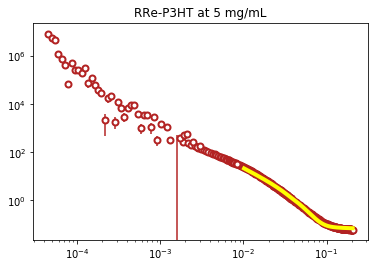

In [98]:
key = 'TU11'
kernel = load_model("flexible_cylinder")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans = usans_data[key]

mask = np.where(sans_load.x>0.01)
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])

# initial parameter values

scale = Parameter(0.003, name='scale').range(0,1)
background = Parameter(0.06, name='background').range(0,0.1)

length = Parameter(3000,name='length',limits=[0,inf]).range(0,inf)
length_pd = Parameter(0)

kuhn_length = Parameter(200,name='kuhn length',limits=[0,inf]).range(0,300)
kuhn_length_pd = Parameter(0)

radius = Parameter(50,name='radius',limits=[0,inf]).range(0,100)
radius_pd = Parameter(0.3)

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    length=length,
    length_pd=length_pd,
    kuhn_length=kuhn_length,
    kuhn_length_pd=kuhn_length_pd,
    radius=radius,
    radius_pd=radius_pd,
    radius_pd_type = 'lognormal',
    sld=sld,
    sld_solvent=sld_solvent,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

## PS-H8 at 45 mg/mL Sample (TU20)

final chisq 1.762(15)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                        background PS-H8 0.06938(30)     0.06938(23)    
                                rg PS-H8 39.967(88)      39.967(66)     
                             scale PS-H8 1.2640(26)      1.2640(20)     


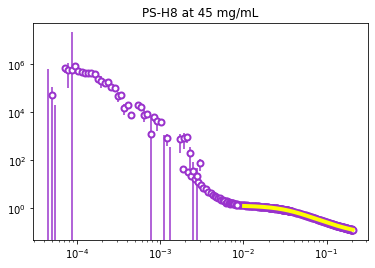

In [99]:
key = 'TU20'
kernel = load_model("polymer_excl_volume")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans = usans_data[key]

mask = np.where(sans_load.x>0.01)
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])

# initial parameter values

scale_H8 = Parameter(1, name='scale PS-H8').range(0,inf)
background_H8 = Parameter(0.12, name='background PS-H8').range(0,1)
rg_H8 = Parameter(100,name='rg PS-H8').range(0,1000)
porod_exp_H8 = Parameter(5/3,name='porod exp PS-H8')

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale_H8,
    background=background_H8,
    rg=rg_H8,
    porod_exp=porod_exp_H8,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])
plt.xscale('log')
plt.yscale('log')

## PS-D8 at 45 mg/mL Sample (TU25)

final chisq 1.470(15)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                        background PS-D8 0.05402(16)     0.05402(13)    
                                rg PS-D8 48.23(81)       48.23(67)      
                             scale PS-D8 0.0946(15)      0.0946(12)     


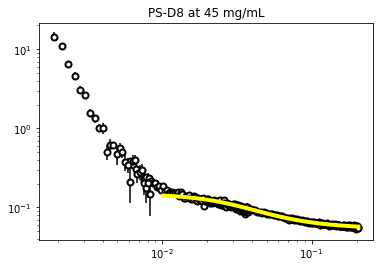

In [100]:
key = 'TU25'
kernel = load_model("polymer_excl_volume")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
#usans = usans_data[key]

mask = np.where(sans_load.x>0.01)
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])

# initial parameter values

scale_D8 = Parameter(1, name='scale PS-D8').range(0,inf)
background_D8 = Parameter(0.12, name='background PS-D8').range(0,1)
rg_D8 = Parameter(100,name='rg PS-D8').range(0,1000)
porod_exp_D8 = Parameter(5/3,name='porod exp PS-D8')

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale_D8,
    background=background_D8,
    rg=rg_D8,
    porod_exp=porod_exp_D8,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color='black')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])
plt.xscale('log')
plt.yscale('log')

## RRe-P3HT at 5 mg/mL and PS-H8 at 45 mg/mL Sample (TU19)

final chisq 25.355(20)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                           B kuhn length 53.97(88)       53.97(18)      
                                B radius 32.573(57)      32.573(11)     
                                 B scale 0.001713(17)    0.0017134(34)  
                              background 0.08579(17)     0.085794(34)   


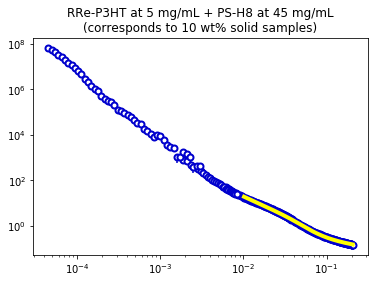

In [101]:
key = 'TU19'
kernel = load_model("polymer_excl_volume+flexible_cylinder")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans = usans_data[key]

mask = np.where(sans_load.x>0.01)
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])

# initial parameter values
scale = Parameter(1)
background = Parameter(background_H8.value, name='background').range(0,1)


A_scale = Parameter(scale_H8.value, name='A scale')
A_rg = Parameter(rg_H8.value,name='A rg')
A_porod_exp = Parameter(porod_exp_H8.value,name='A porod exp')


B_scale_H8 = Parameter(0.002, name='B scale').range(0,1)

B_length_H8 = Parameter(3000000,name='B length',limits=[0,inf])
B_length_pd_H8 = Parameter(0)

B_kuhn_length_H8 = Parameter(kuhn_length.value,name='B kuhn length',limits=[0,inf]).range(0,inf)
B_kuhn_length_pd_H8 = Parameter(kuhn_length_pd.value)

B_radius_H8 = Parameter(radius.value,name='B radius',limits=[0,inf]).range(0,100)
B_radius_pd_H8 = Parameter(radius_pd.value)

B_sld_H8 = Parameter(slds[cps[key]])
B_sld_solvent_H8 = Parameter(slds[solvent_names[key]])

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_rg=A_rg,
    A_porod_exp=A_porod_exp,
    B_scale=B_scale_H8,
    B_length=B_length_H8,
    B_length_pd=B_length_pd_H8,
    B_kuhn_length=B_kuhn_length_H8,
    B_kuhn_length_pd=B_kuhn_length_pd_H8,
    B_radius=B_radius_H8,
    B_radius_pd=B_radius_pd_H8,
    B_radius_pd_type = 'lognormal',
    B_sld=B_sld_H8,
    B_sld_solvent=B_sld_solvent_H8,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')

plt.title(names[key])
plt.xscale('log')
plt.yscale('log')

## RRe-P3HT at 5 mg/mL and PS-D8 at 45 mg/mL Sample (TU24)

final chisq 9.554(20)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                           B kuhn length 69.77(68)       69.77(22)      
                                B radius 36.994(69)      36.994(22)     
                                 B scale 0.0017091(79)   0.0017091(25)  
                              background 0.06436(10)     0.064358(33)   


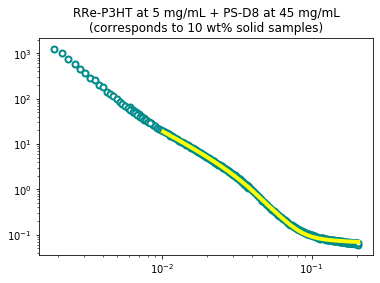

In [102]:
key = 'TU24'
kernel = load_model("polymer_excl_volume+flexible_cylinder")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
#usans = usans_data[key]

mask = np.where(sans_load.x>0.01)
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])

# initial parameter values
scale = Parameter(1)
background = Parameter(background_D8.value, name='background').range(0,1)


A_scale = Parameter(scale_D8.value, name='A scale')
A_rg = Parameter(rg_D8.value,name='A rg')
A_porod_exp = Parameter(porod_exp_D8.value,name='A porod exp')


B_scale_D8 = Parameter(0.002, name='B scale').range(0,1)

B_length_D8 = Parameter(3000000,name='B length',limits=[0,inf])
B_length_pd_D8 = Parameter(0)

B_kuhn_length_D8 = Parameter(kuhn_length.value,name='B kuhn length',limits=[0,inf]).range(0,inf)
B_kuhn_length_pd_D8 = Parameter(kuhn_length_pd.value)

B_radius_D8 = Parameter(radius.value,name='B radius',limits=[0,inf]).range(0,100)
B_radius_pd_D8 = Parameter(radius_pd.value)

B_sld_D8 = Parameter(slds[cps[key]])
B_sld_solvent_D8 = Parameter(slds[solvent_names[key]])

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_rg=A_rg,
    A_porod_exp=A_porod_exp,
    B_scale=B_scale_D8,
    B_length=B_length_D8,
    B_length_pd=B_length_pd_D8,
    B_kuhn_length=B_kuhn_length_D8,
    B_kuhn_length_pd=B_kuhn_length_pd_D8,
    B_radius=B_radius_D8,
    B_radius_pd=B_radius_pd_D8,
    B_radius_pd_type = 'lognormal',
    B_sld=B_sld_D8,
    B_sld_solvent=B_sld_solvent_D8,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color='black')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')

plt.title(names[key])
plt.xscale('log')
plt.yscale('log')

## Plotting Fit Results

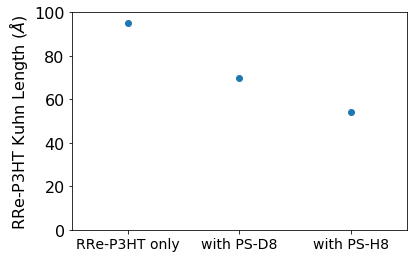

In [113]:
# RRe-P3HT Kuhn Length
x = [1,2,3]
y = [kuhn_length.value, B_kuhn_length_D8.value, B_kuhn_length_H8.value]
labels = ['RRe-P3HT only', 'with PS-D8', 'with PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=14)
plt.yticks(fontsize=16)
plt.ylabel('RRe-P3HT Kuhn Length ($\AA$)',fontsize=16)
plt.xlim(0.5,3.5)
plt.ylim(0,100)
plt.show()

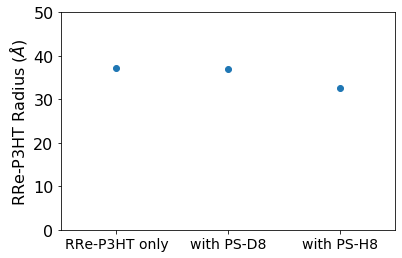

In [114]:
# RRe-P3HT Radius
x = [1,2,3]
y = [radius.value, B_radius_D8.value, B_radius_H8.value]
labels = ['RRe-P3HT only', 'with PS-D8', 'with PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=14)
plt.yticks(fontsize=16)
plt.ylabel('RRe-P3HT Radius ($\AA$)',fontsize=16)
plt.xlim(0.5,3.5)
plt.ylim(0,50)
plt.show()

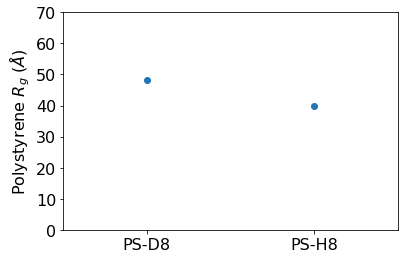

In [115]:
# PS Rg
x = [1,2]
y = [rg_D8.value, rg_H8.value]
labels = ['PS-D8', 'PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Polystyrene $R_g$ ($\AA$)',fontsize=16)
plt.xlim(0.5,2.5)
plt.ylim(0,70)
plt.show()